# MNIST Classification with a Simple Neural Network

This notebook downloads the MNIST dataset, inspects the data, trains a small fully connected neural network, and evaluates the model on the test set. Everything runs on either CPU or GPU and is compatible with Google Colab.

## 1. Environment setup

Import the required libraries and select the available device.

In [1]:
exercise_path = "/content/mnist-exercise"
!rm -rf {exercise_path}
!git clone https://github.com/zivbeker42/mnist-exercise.git {exercise_path}
import sys
sys.path.append(exercise_path)


Cloning into '/content/mnist-exercise'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 7 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 6.26 KiB | 6.26 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from mnist_nn import SimpleMNISTClassifier, accuracy, count_parameters

SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data_dir = Path("sample_data")
data_dir.mkdir(exist_ok=True)

Using device: cuda


## 2. Download and prepare the dataset

Load the MNIST dataset, split the training data into training and validation sets, and create PyTorch data loaders.

In [4]:
transform = transforms.ToTensor()

full_train_dataset = datasets.MNIST(
    root=data_dir, train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root=data_dir, train=False, download=True, transform=transform
)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

len(train_dataset), len(val_dataset), len(test_dataset)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.72MB/s]


(54000, 6000, 10000)

## 3. Inspect the data

Check dataset statistics, visualize a batch of images, and verify label distribution.

Mean pixel value: 0.1258
Std pixel value: 0.3024
Label distribution (counts for digits 0-9):
[50, 69, 52, 52, 52, 41, 46, 54, 40, 56]


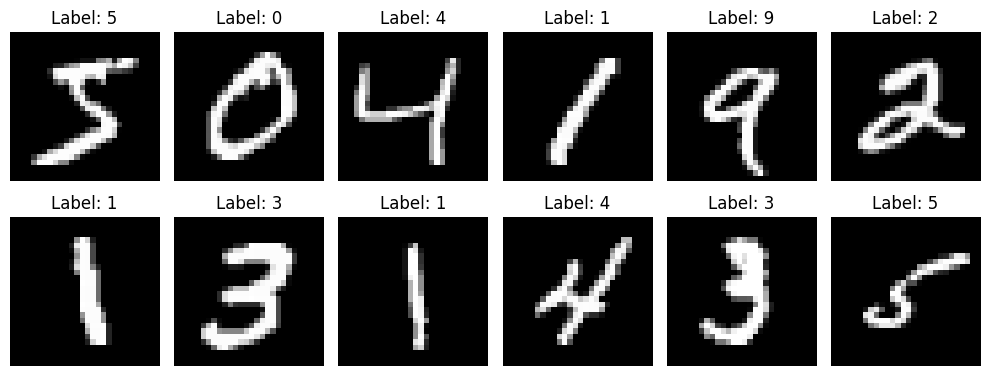

In [5]:
sample_loader = DataLoader(full_train_dataset, batch_size=512)
images, labels = next(iter(sample_loader))
mean_pixel = images.mean().item()
std_pixel = images.std().item()
label_counts = torch.bincount(labels, minlength=10)

print(f"Mean pixel value: {mean_pixel:.4f}")
print(f"Std pixel value: {std_pixel:.4f}")
print("Label distribution (counts for digits 0-9):")
print(label_counts.tolist())

fig, axes = plt.subplots(2, 6, figsize=(10, 4))
for ax, img, label in zip(axes.flatten(), images[:12], labels[:12]):
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.set_title(f"Label: {label.item()}")
    ax.axis("off")
fig.tight_layout()
plt.show()

## 4. Build the model

Instantiate the neural network and inspect the number of trainable parameters.

In [14]:
model = SimpleMNISTClassifier(hidden_units=16).to(device)
print(model)
print(f"Trainable parameters: {count_parameters(model):,}")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

SimpleMNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Trainable parameters: 12,730


## 5. Train the network

Train for a few epochs while tracking training and validation metrics.

In [15]:
def run_epoch(model, loader, loss_fn, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    epoch_loss = 0.0
    epoch_acc = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)
        batch_acc = accuracy(logits, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        epoch_acc += batch_acc.item() * images.size(0)

    dataset_size = len(loader.dataset)
    return epoch_loss / dataset_size, epoch_acc / dataset_size


num_epochs = 16
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = run_epoch(model, val_loader, loss_fn)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch}/{num_epochs} - "
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
        f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}"
    )

Epoch 1/16 - Train loss: 0.7120, Train acc: 0.8136, Val loss: 0.3545, Val acc: 0.8997
Epoch 2/16 - Train loss: 0.3076, Train acc: 0.9141, Val loss: 0.2933, Val acc: 0.9142
Epoch 3/16 - Train loss: 0.2630, Train acc: 0.9257, Val loss: 0.2646, Val acc: 0.9243
Epoch 4/16 - Train loss: 0.2375, Train acc: 0.9321, Val loss: 0.2493, Val acc: 0.9293
Epoch 5/16 - Train loss: 0.2193, Train acc: 0.9372, Val loss: 0.2425, Val acc: 0.9270
Epoch 6/16 - Train loss: 0.2064, Train acc: 0.9403, Val loss: 0.2271, Val acc: 0.9335
Epoch 7/16 - Train loss: 0.1952, Train acc: 0.9432, Val loss: 0.2193, Val acc: 0.9360
Epoch 8/16 - Train loss: 0.1865, Train acc: 0.9466, Val loss: 0.2163, Val acc: 0.9375
Epoch 9/16 - Train loss: 0.1790, Train acc: 0.9481, Val loss: 0.2087, Val acc: 0.9380
Epoch 10/16 - Train loss: 0.1730, Train acc: 0.9494, Val loss: 0.2105, Val acc: 0.9395
Epoch 11/16 - Train loss: 0.1673, Train acc: 0.9519, Val loss: 0.2032, Val acc: 0.9408
Epoch 12/16 - Train loss: 0.1627, Train acc: 0.9526,

## 6. Plot training history

Visualize how the training and validation metrics evolved.

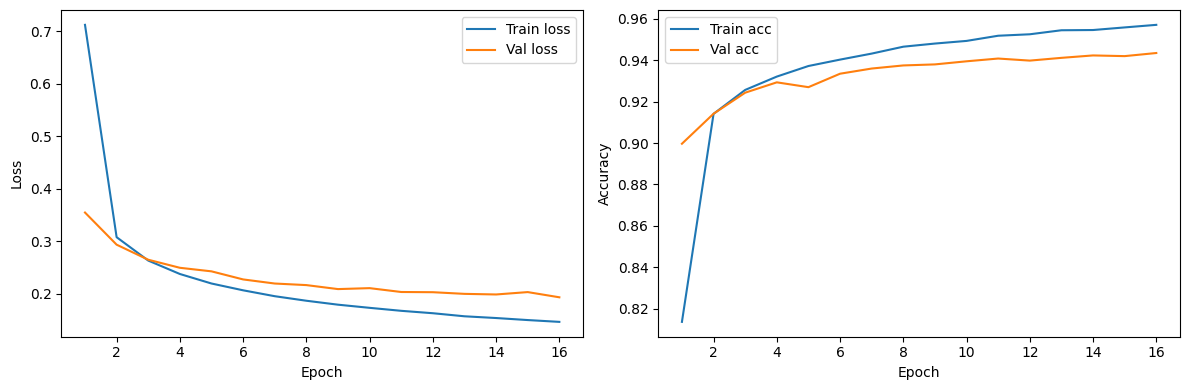

In [16]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluate on the test set

Measure performance on unseen data and inspect a few predictions.

In [17]:
test_loss, test_acc = run_epoch(model, test_loader, loss_fn)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
with torch.no_grad():
    probabilities = model(test_images, apply_softmax=True)
    predicted_labels = probabilities.argmax(dim=1)

for idx in range(5):
    print(
        f"Image {idx}: True label = {test_labels[idx].item()}, "
        f"Predicted = {predicted_labels[idx].item()}, "
        f"Confidence = {probabilities[idx, predicted_labels[idx]].item():.2f}"
    )

Test loss: 0.1696
Test accuracy: 0.9491
Image 0: True label = 7, Predicted = 7, Confidence = 0.99
Image 1: True label = 2, Predicted = 2, Confidence = 0.98
Image 2: True label = 1, Predicted = 1, Confidence = 0.99
Image 3: True label = 0, Predicted = 0, Confidence = 1.00
Image 4: True label = 4, Predicted = 4, Confidence = 0.95
